# Model comparison to GLODAP along GO-SHIP Easy Ocean lines
This notebook shows a means of comparing MOM6 ocean model data to GLODAP data along the WOCE/GO-SHIP sections. GLODAP data are taken from the cruises used to construct the Easy Ocean lines. Model data are interpolated onto the cruis station locations using `xesmf`. See [here](https://www.glodap.info/) for information on GLODAP, and [here](https://cchdo.ucsd.edu/products/goship-easyocean) for information on the Easy Ocean lines.

In [1]:
import pandas as pd
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata
import geopy
import cmocean
import gsw
from geopy import distance
import xesmf as xe
import sectionate
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/src')
import src
from src import *

In [50]:
plotsdir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/figures/" + x
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/model/yearly_output_0.25deg/" + x
obsdatadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/observations/" + x


In [51]:
def GLODAPP_LON_to_CM4X(lons):
    lons_copy = 1 * lons 
    lons_copy[lons_copy > 60] -= 360
    return lons_copy
def CM4X_LON_to_GLODAPP(lons): 
    lons_copy = 1 * lons 
    lons_copy[(lons_copy > -300) * (lons_copy < -180)] +=360
    return lons_copy

def CM4X_to_reg_grid(ds): 
    xhcopy = 1 * ds.xh.values
    xhcopy[(ds.xh > -300) * (ds.xh < -180)] += 360
    
    ds_copy = 1 * ds
    ds_copy.coords['xh'] = 1 * xhcopy

    return ds_copy.reindex({ "xh" : xhcopy})


def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")

## Read GLODAP data

In [52]:
df = pd.read_csv(obsdatadir('GLODAPv2.2023_Merged_Master_File.csv'),na_values=9999)
df = df.replace(-9999, np.nan)

/tmp/ipykernel_74271/333209176.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(obsdatadir('GLODAPv2.2023_Merged_Master_File.csv'),na_values=9999)


## Plot options
Specify a WOCE/GO-SHIP section line to look at, and a year range for the model.

In [53]:
line = 'SR04'
time = '1990-2014'

In [54]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmolkg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmolkg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'BrBG','units':'fmolkg-1'},
    'thetao':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

## Read GO-SHIP Easy Ocean data

In [56]:
rootdir = glob.glob(obsdatadir('GO-SHIP/gridded/*/')+line)[0]
# Get merged netcdf file
filename = line.lower()+'.nc'
path = '/'.join([rootdir,filename])
dso_nc = xr.open_dataset(path)

## Match GLODAP data with cruises used for Easy Ocean
(via the `expocode`)

In [57]:
dfo = match_GLODAPP_WOCE(df, dso_nc)

Available cruise data : 06AQ20101128 06AQ20080210 06AQ20050122


## Derive sections for each cruise, and corresponding model data

In [58]:
sections = extract_GLODAPP_cruises(dfo)
for (i, cruise) in enumerate(sections.keys()):
    sections[cruise] = get_thetao(sections[cruise])

## Plot section locations

2005.0
2008.0
2010.2728776185227


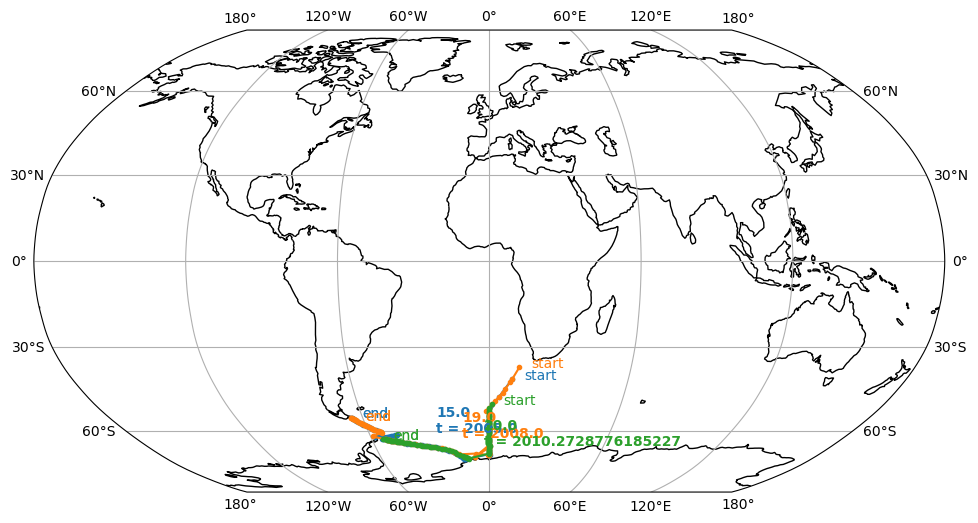

In [127]:
fig,ax=plt.subplots(figsize=(12,6),subplot_kw={'projection':ccrs.Robinson(central_longitude = 0)})
ax.set_global()
ax.coastlines()
gl = ax.gridlines(draw_labels = True)

for cruise,section in sections.items():
    x = CM4X_LON_to_GLODAPP(section['lon'])
    y = section['lat']
    l = ax.plot(x,y,transform=ccrs.PlateCarree(),marker='.')
    print(section.time.values)
    color = l[0].get_color()
    ax.text(x[int(len(x)/2)]+10,y[int(len(y)/2)] + 5,str(cruise) + "\nt = " + str(section.time.values),transform=ccrs.PlateCarree(),color=color,fontweight='bold',horizontalalignment='left')
    ax.text(x[0]+5,y[0],'start',transform=ccrs.PlateCarree(),color=color,horizontalalignment='left')
    ax.text(x[-1]+5,y[-1],'end',transform=ccrs.PlateCarree(),color=color,horizontalalignment='left')
    ax.text(x[-1]+5,y[-1],'end',transform=ccrs.PlateCarree(),color=color,horizontalalignment='left')

fig.savefig(plotsdir(line + "_MAP.png"), dpi = 400, bbox_inches = "tight")

In [66]:
cruise_times = np.array([int(s.time.values) for s in sections.values()])

## Plot load CM4X data

In [67]:
def read_CM4X(fname): 
    ds = xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":-1, "longitude":-1},
        engine="zarr")
    ds = approximate_z(ds)
    ds = ds.sel(year = slice(cruise_times.min(), cruise_times.max())).mean("year")

    ds["z"] = ds["z"].transpose("zl", "yh", "xh")
    ds["thkcello"] = ds["thkcello"].transpose("zl", "yh", "xh")

    ds = ds.drop(["lat", "lon"])
    ds = ds.rename({"geolat":"lat", "geolon":"lon"})
    ds = get_sigma2(ds)
    return ds

ds = read_CM4X(datadir("CM4Xp125_historical_transient_tracers.zarr"))

/tmp/ipykernel_74271/1369048363.py:16: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.drop(["lat", "lon"])


In [69]:
sections_dsm = {}
for cruise, section in sections.items():
    regridder = xe.Regridder(ds, sections[cruise][["lon", "lat"]], method = "bilinear", periodic = True, locstream_out=True)
    section_dsm = regridder(ds)

    print("Cruise #: ", cruise)

    # Apply conversion
    for key,value in variable_kwargs.items():
        if key in section_dsm.keys():
            print(key)
            section_dsm[key] = section_dsm[key]*variable_kwargs[key]['conversion']
    # section_dsm = section_dsm.where(section_dsm.thkcello > 1e-10)
    sections_dsm[cruise] = 1 * section_dsm

Cruise #:  15.0
cfc12
cfc11
sf6
thetao
Cruise #:  19.0
cfc12
cfc11
sf6
thetao
Cruise #:  20.0
cfc12
cfc11
sf6
thetao


In [160]:
new_z_grid = -1 * np.concatenate((np.linspace(0.1, 3000, 30), np.linspace(3025, 4000, 41), np.linspace(4000, 6000, 20)))

In [ ]:
sections_dsmo = {}
for cruise,section_dsm in sections_dsm.items():
    print(cruise)
    sections_tmp = 1 * sections_dsm[cruise]
    sections_tmp = sections_tmp.where(sections_tmp.thkcello > 1e-9)
    sections_dsmo[cruise] = 1 * interpolate_section(sections_tmp.compute(), new_z_grid, 
                    interp_coord = "z",iterate_coord =  "distance", kind = "linear")

15.0


In [ ]:
sections_obs_interp = {}
for cruise,section_dsm in sections.items():
    print(cruise)
    sections_tmp = 1 * sections[cruise]
    sections_obs_interp[cruise] = interpolate_section(sections_tmp[["thetao", "z"]].compute(), new_z_grid, 
                    interp_coord = "z",iterate_coord =  "distance", kind = "linear")

### plotting functions

In [ ]:
def save_section_fig(fig, product, section, variable):
    fig.savefig(plotsdir(product + "_" + section + "_" + variable + ".png"), dpi = 400, bbox_inches = "tight")


## Plot sections of temperature

In [ ]:
variable = 'thetao'
levels = np.arange(-2, 5, 0.5)
cmap = cmocean.cm.deep
units = "°C"
fig,axes = plt.subplots(1, 3, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes[i]
    im2 = ax.contourf(sections_obs_interp[cruise]["distance"], sections_obs_interp[cruise]["z"], 
                      sections_obs_interp[cruise][variable],
                     cmap=cmap, levels = levels, extend = "both")
    ax.set_xlabel('Distance along section [km]')
    t = np.int32(sections[cruise].time.values); t = str(t)
    ax.set_title(variable+'; Cruise number : '+str(cruise) + "; t = " + t)
    ax.set_ylim(-5000, 0)
    ax.set_xlim(sections[cruise].distance.min(), sections[cruise].distance.max())

fig.subplots_adjust(wspace = 0.05)
fig.suptitle("GLODAP Obsersvations")
axes[0].set_xlim(100_000, 300_000)
axes[1].set_xlim(150_000, 350_000)
axes[2].set_xlim(50_000, None)
axes[0].set_ylim(-4700, -1000)

variable = 'thetao'
units = "°C"
fig,axes = plt.subplots(1, 3, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes[i]
    im = ax.contourf(sections_dsmo[cruise].distance, sections_dsmo[cruise].z, 
                     sections_dsmo[cruise][variable], 
                     cmap=cmap, levels = levels, extend = "both")
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise) + "; t = " + str(cruise_times.min()) + "-" + str(cruise_times.max()) )
    ax.set_ylim(-5000, 0)
    # fig.colorbar(im2, ax = ax, label = "deg C", orientation = "vertical", fraction = 0.04)

fig.subplots_adjust(wspace = 0.05)
fig.suptitle("CM4X Output")
save_section_fig(fig, "CM4X", line, variable)

axes[0].set_xlim(100_000, 300_000)
axes[1].set_xlim(150_000, 350_000)
axes[2].set_xlim(50_000, None)
axes[0].set_ylim(-4700, -1000)